# 1. Kaggle 房价竞赛


In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt  # 替换d2l的绘图功能
%matplotlib inline

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('.', '01_data/02_DataSet_Kaggle_House')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        with zipfile.ZipFile(fname, 'r') as fp:
            fp.extractall(base_dir)
    elif ext in ('.tar', '.gz'):
        with tarfile.open(fname, 'r') as fp:
            fp.extractall(base_dir)
    else:
        raise ValueError('只有zip/tar文件可以被解压缩')
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

# 设置数据集
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc9370b9160e7921475fbcd7d31219ce'
)

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

# 加载数据
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

# 查看数据形状
print(train_data.shape)  # (1460, 81) 1460个样本，80个特征，1个标签
print(test_data.shape)   # (1459, 80) 测试样本没有标签

# 查看前几行数据
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载.\01_data/02_DataSet_Kaggle_House\kaggle_house_pred_train.csv...
(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [2]:
# 在每个样本中，第一个特征是ID，将其从数据集中删除
all_features = pd.concat(
    (train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])
)  # 从第2列开始，第1列没有了
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml


In [12]:
# 将所有缺失的值替换成相应特征的平均值
# 通过将特征重新缩放到零均值和单位方差来标准化数据
print(all_features.dtypes)  # 可以知道每一列分别为什么类型特征
numeric_features = all_features.dtypes[
    all_features.dtypes != "object"
].index  # 当值的类型不是object的话，就是一个数值
print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)  # 对数值数据变为总体为均值为0，方差为1的分布的数据
all_features[numeric_features] = all_features[numeric_features].fillna(
    0
)  # 将数值数据中not number的数据用0填充

MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
SaleCondition_nan           bool
Length: 330, dtype: object
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=330)


In [13]:
# 处理离散值。用一次独热编码替换它们
# 若一列里面有五个不同的值，则创建五个features，如果该列中为该feature则为1，不为该feature则为0
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [21]:
# 从pandas格式中提取Numpy格式，并将其转换为张量表示
print(train_data.shape)
n_train = train_data.shape[0]  # 样本个数
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# train_data的SalePrice列是label值
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

(1460, 81)


In [15]:
# 训练
loss = nn.MSELoss()
print(train_features.shape[1])  # 所有特征个数
in_features = train_features.shape[1]


def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))  # 单层线性回归
    return net

330


① 我们更关心相对误差$\frac{y - \hat{y}}{y}$，解决这个问题的一种方法是用价格预测的对数来衡量差异。

② 100 万的房子，预测与真实值相差 5 万，10 万的房子，预测与真实值相差 5 万，是不一样的。


In [16]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(
        net(features), 1, float("inf")
    )  # 把模型输出的值限制在1和inf之间，inf代表无穷大（infinity的缩写）
    rmse = torch.sqrt(
        loss(torch.log(clipped_preds), torch.log(labels))
    )  # 预测做log，label做log，然后丢到MSE损失函数里
    return rmse.item()

In [17]:
# 训练函数将借助Adam优化器
def train(
    net,
    train_features,
    train_labels,
    test_features,
    test_labels,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(
        net.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [18]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):  # 给定k折，给定第几折，返回相应的训练集、测试集
    assert k > 1
    fold_size = X.shape[0] // k  # 每一折的大小为样本数除以k
    X_train, y_train = None, None
    for j in range(k):  # 每一折
        idx = slice(j * fold_size, (j + 1) * fold_size)  # 每一折的切片索引间隔
        X_part, y_part = X[idx, :], y[idx]  # 把每一折对应部分取出来
        if j == i:  # i表示第几折，把它作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:  # 第一次看到X_train，则把它存起来
            X_train, y_train = X_part, y_part
        else:  # 后面再看到，除了第i外，其余折也作为训练数据集，用torch.cat将原先的合并
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid  # 返回训练集和验证集

In [22]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(
            k, i, X_train, y_train
        )  # 把第i折对应分开的数据集、验证集拿出来
        net = get_net()
        # *是解码，变成前面返回的四个数据
        train_ls, valid_ls = train(
            net, *data, num_epochs, learning_rate, weight_decay, batch_size
        )  # 训练集、验证集丢进train函数

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(
                list(range(1, num_epochs + 1)),
                [train_ls, valid_ls],
                xlabel="epoch",
                ylabel="rmse",
                xlim=[1, num_epochs],
                legend=["train", "valid"],
                yscale="log",
            )
        print(
            f"fold{i+1},train log rmse {float(train_ls[-1]):f},"
            f"valid log rmse {float (valid_ls[-1]):f}"
        )
    return train_l_sum / k, valid_l_sum / k  # 求和做平均

In [20]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(
    k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size
)
print(
    f"{k}-折验证：平均训练log rmse：{float(train_l):f},"
    f"平均验证log rmse：{float(valid_l):f}"
)

NameError: name 'd2l' is not defined

train log rmse 0.162608


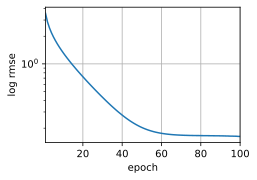

In [ ]:
def train_and_pred(
    train_features,
    test_feature,
    train_labels,
    test_data,
    num_epochs,
    lr,
    weight_decay,
    batch_size,
):
    net = get_net()
    train_ls, _ = train(
        net,
        train_features,
        train_labels,
        None,
        None,
        num_epochs,
        lr,
        weight_decay,
        batch_size,
    )
    d2l.plot(
        np.arange(1, num_epochs + 1),
        [train_ls],
        xlabel="epoch",
        ylabel="log rmse",
        xlim=[1, num_epochs],
        yscale="log",
    )
    print(f"train log rmse {float(train_ls[-1]):f}")
    preds = net(test_features).detach().numpy()
    test_data["SalePrice"] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data["Id"], test_data["SalePrice"]], axis=1)
    submission.to_csv("submission.cvs", index=False)


train_and_pred(
    train_features,
    test_features,
    train_labels,
    test_data,
    num_epochs,
    lr,
    weight_decay,
    batch_size,
)